In [ ]:
%%capture
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import keras as k
from keras.layers import Dense, LSTMCell, LSTM
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = True

# 1. Carga de data.
**********************************

In [ ]:
df = pd.read_pickle('el_df.pkl')
date_time = pd.to_datetime(df.index, format = '%Y-%m-%d %H:%M:%S')
df = df.reset_index()
df.pop('Fecha')
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


Veamos el factor temporal, notemos si es posible ver una recurrecia en los datos en torno al tiempo.

Text(0.5, 1.0, 'Gráfico recurrencia en el tiempo - 5 días.')

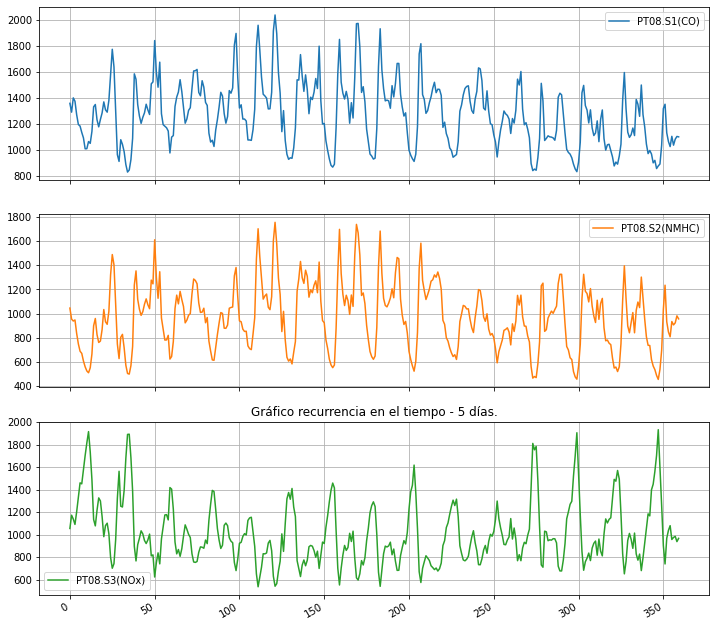

In [ ]:
feat = ['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)']
plot_feat = df[feat][:360]
plot_feat.index = df.index[:360]
_ = plot_feat.plot(subplots=True)
plt.title('Gráfico recurrencia en el tiempo - 5 días.')

Variable anterior
****************

In [ ]:
df_new = {col: list(df[col][24:-24]) for col in df.columns}
L = len(df['PT08.S1(CO)'][24:-24])
print(L)
for i in range(24):
  df_new['PT08 -'+str(i+1)] = list(df['PT08.S1(CO)'][24-(i+1):][:L])

9309


In [ ]:
df_new = pd.DataFrame(df_new)
df2 = df_new
df2.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08 -1,PT08 -2,PT08 -3,PT08 -4,PT08 -5,PT08 -6,PT08 -7,PT08 -8,PT08 -9,PT08 -10,PT08 -11,PT08 -12,PT08 -13,PT08 -14,PT08 -15,PT08 -16,PT08 -17,PT08 -18,PT08 -19,PT08 -20,PT08 -21,PT08 -22,PT08 -23,PT08 -24
0,1581.0,1319.0,799.0,2083.0,1409.0,10.3,64.2,0.8065,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0,1292.0,1360.0
1,1776.0,1488.0,702.0,2333.0,1704.0,9.7,69.3,0.8319,1581.0,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0,1292.0
2,1640.0,1404.0,743.0,2191.0,1654.0,9.6,67.8,0.8133,1776.0,1581.0,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0
3,1313.0,1076.0,957.0,1707.0,1285.0,9.1,64.0,0.7419,1640.0,1776.0,1581.0,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0
4,965.0,749.0,1325.0,1333.0,821.0,8.2,63.4,0.6905,1313.0,1640.0,1776.0,1581.0,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0


In [ ]:
#Base polinomial de orden 2
for col in df2.columns:
  df2[col + ' ^2'] = df2[col]**2

In [ ]:
# # Agregar Output
# for i in range(24):
#   df2['out-'+str(i+1)] = list(df['PT08.S1(CO)'][24+(i+1):][:L])

df2.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08 -1,PT08 -2,PT08 -3,PT08 -4,PT08 -5,PT08 -6,PT08 -7,PT08 -8,PT08 -9,PT08 -10,PT08 -11,PT08 -12,PT08 -13,PT08 -14,PT08 -15,PT08 -16,PT08 -17,PT08 -18,PT08 -19,PT08 -20,PT08 -21,PT08 -22,PT08 -23,PT08 -24,PT08.S1(CO) ^2,PT08.S2(NMHC) ^2,PT08.S3(NOx) ^2,PT08.S4(NO2) ^2,PT08.S5(O3) ^2,T ^2,RH ^2,AH ^2,PT08 -1 ^2,PT08 -2 ^2,PT08 -3 ^2,PT08 -4 ^2,PT08 -5 ^2,PT08 -6 ^2,PT08 -7 ^2,PT08 -8 ^2,PT08 -9 ^2,PT08 -10 ^2,PT08 -11 ^2,PT08 -12 ^2,PT08 -13 ^2,PT08 -14 ^2,PT08 -15 ^2,PT08 -16 ^2,PT08 -17 ^2,PT08 -18 ^2,PT08 -19 ^2,PT08 -20 ^2,PT08 -21 ^2,PT08 -22 ^2,PT08 -23 ^2,PT08 -24 ^2
0,1581.0,1319.0,799.0,2083.0,1409.0,10.3,64.2,0.8065,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0,1292.0,1360.0,2499561.0,1739761.0,638401.0,4338889.0,1985281.0,106.09,4121.64,0.650442,1912689.0,1669264.0,1716100.0,1879641.0,1653796.0,1527696.0,1390041.0,1520289.0,1825201.0,1776889.0,1308736.0,1106704.0,1136356.0,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0,1893376.0,1965604.0,1669264.0,1849600.0
1,1776.0,1488.0,702.0,2333.0,1704.0,9.7,69.3,0.8319,1581.0,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0,1292.0,3154176.0,2214144.0,492804.0,5442889.0,2903616.0,94.09,4802.49,0.692058,2499561.0,1912689.0,1669264.0,1716100.0,1879641.0,1653796.0,1527696.0,1390041.0,1520289.0,1825201.0,1776889.0,1308736.0,1106704.0,1136356.0,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0,1893376.0,1965604.0,1669264.0
2,1640.0,1404.0,743.0,2191.0,1654.0,9.6,67.8,0.8133,1776.0,1581.0,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0,2689600.0,1971216.0,552049.0,4800481.0,2735716.0,92.16,4596.84,0.661457,3154176.0,2499561.0,1912689.0,1669264.0,1716100.0,1879641.0,1653796.0,1527696.0,1390041.0,1520289.0,1825201.0,1776889.0,1308736.0,1106704.0,1136356.0,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0,1893376.0,1965604.0
3,1313.0,1076.0,957.0,1707.0,1285.0,9.1,64.0,0.7419,1640.0,1776.0,1581.0,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1723969.0,1157776.0,915849.0,2913849.0,1651225.0,82.81,4096.00,0.550416,2689600.0,3154176.0,2499561.0,1912689.0,1669264.0,1716100.0,1879641.0,1653796.0,1527696.0,1390041.0,1520289.0,1825201.0,1776889.0,1308736.0,1106704.0,1136356.0,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0,1893376.0
4,965.0,749.0,1325.0,1333.0,821.0,8.2,63.4,0.6905,1313.0,1640.0,1776.0,1581.0,1383.0,1292.0,1310.0,1371.0,1286.0,1236.0,1179.0,1233.0,1351.0,1333.0,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,931225.0,561001.0,1755625.0,1776889.0,674041.0,67.24,4019.56,0.476790,1723969.0,2689600.0,3154176.0,2499561.0,1912689.0,1669264.0,1716100.0,1879641.0,1653796.0,1527696.0,1390041.0,1520289.0,1825201.0,1776889.0,1308736.0,1106704.0,1136356.0,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0


In [ ]:
df = df2

# Separación de la data.
*******************************
Ocuparemos los siguientes porcentajes para separar la base de datos: 70% para el subconjunto de entrenamiento, 20% para el subconjunto de validación y 10% para el subconjunto de testeo. Cabe aclarar que esta sample será ordenado, para poder considerar el paso temporal entre una observación y la siguiente.

In [ ]:
n = np.shape(df)[0]
trainset = df[0:int(0.7*n)]
valset = df[int(0.7*n):int(0.9*n)]
testset = df[int(0.9*n):]
num_features = df.shape[1]
num_features

64

### Normalización de los datos.

In [ ]:
df.columns

Index(['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'PT08 -1', 'PT08 -2', 'PT08 -3',
       'PT08 -4', 'PT08 -5', 'PT08 -6', 'PT08 -7', 'PT08 -8', 'PT08 -9',
       'PT08 -10', 'PT08 -11', 'PT08 -12', 'PT08 -13', 'PT08 -14', 'PT08 -15',
       'PT08 -16', 'PT08 -17', 'PT08 -18', 'PT08 -19', 'PT08 -20', 'PT08 -21',
       'PT08 -22', 'PT08 -23', 'PT08 -24', 'PT08.S1(CO) ^2',
       'PT08.S2(NMHC) ^2', 'PT08.S3(NOx) ^2', 'PT08.S4(NO2) ^2',
       'PT08.S5(O3) ^2', 'T ^2', 'RH ^2', 'AH ^2', 'PT08 -1 ^2', 'PT08 -2 ^2',
       'PT08 -3 ^2', 'PT08 -4 ^2', 'PT08 -5 ^2', 'PT08 -6 ^2', 'PT08 -7 ^2',
       'PT08 -8 ^2', 'PT08 -9 ^2', 'PT08 -10 ^2', 'PT08 -11 ^2', 'PT08 -12 ^2',
       'PT08 -13 ^2', 'PT08 -14 ^2', 'PT08 -15 ^2', 'PT08 -16 ^2',
       'PT08 -17 ^2', 'PT08 -18 ^2', 'PT08 -19 ^2', 'PT08 -20 ^2',
       'PT08 -21 ^2', 'PT08 -22 ^2', 'PT08 -23 ^2', 'PT08 -24 ^2'],
      dtype='object')

In [ ]:
media = trainset.mean()
std = trainset.std()

trainset = (trainset-media)/std
valset = (valset-media)/std
testset = (testset-media)/std

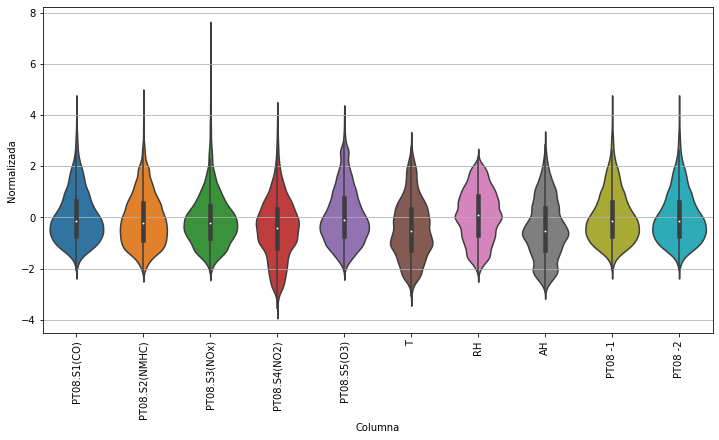

In [ ]:
df_std = (df[df.columns[:10]] - media[:10]) / std[:10]
# df_std = df[df.columns[:10]]
df_std = df_std.melt(var_name='Columna', value_name='Normalizada')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Columna', y='Normalizada', data=df_std)
_ = ax.set_xticklabels(df[:10].keys(), rotation=90)

In [ ]:
trainset.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08 -1,PT08 -2,PT08 -3,PT08 -4,PT08 -5,PT08 -6,PT08 -7,PT08 -8,PT08 -9,PT08 -10,PT08 -11,PT08 -12,PT08 -13,PT08 -14,PT08 -15,PT08 -16,PT08 -17,PT08 -18,PT08 -19,PT08 -20,PT08 -21,PT08 -22,PT08 -23,PT08 -24,PT08.S1(CO) ^2,PT08.S2(NMHC) ^2,PT08.S3(NOx) ^2,PT08.S4(NO2) ^2,PT08.S5(O3) ^2,T ^2,RH ^2,AH ^2,PT08 -1 ^2,PT08 -2 ^2,PT08 -3 ^2,PT08 -4 ^2,PT08 -5 ^2,PT08 -6 ^2,PT08 -7 ^2,PT08 -8 ^2,PT08 -9 ^2,PT08 -10 ^2,PT08 -11 ^2,PT08 -12 ^2,PT08 -13 ^2,PT08 -14 ^2,PT08 -15 ^2,PT08 -16 ^2,PT08 -17 ^2,PT08 -18 ^2,PT08 -19 ^2,PT08 -20 ^2,PT08 -21 ^2,PT08 -22 ^2,PT08 -23 ^2,PT08 -24 ^2
0,2.208743,1.320695,-0.220999,1.728524,1.067801,-1.498649,0.954211,-1.048199,1.301705,0.884853,0.967015,1.245880,0.856620,0.627636,0.366688,0.613816,1.153632,1.071007,0.206133,-0.214773,-0.150630,-0.402206,-0.406650,-0.022129,0.170200,0.394618,0.449753,0.793147,1.269036,1.387763,0.884040,1.194887,2.387555,1.301709,-0.308546,1.812320,0.949182,-1.187421,0.917371,-0.988157,1.261607,0.794596,0.884183,1.197411,0.764223,0.522343,0.258376,0.508061,1.092384,0.999534,0.102149,-0.285029,-0.228117,-0.446982,-0.450730,-0.111838,0.067815,0.285991,0.341000,0.696128,1.223977,1.362162,0.793813,1.139175
1,3.101620,1.953441,-0.608856,2.591454,1.850954,-1.576705,1.246428,-0.976214,2.208262,1.301479,0.884611,0.966651,1.245687,0.856493,0.627582,0.366656,0.613599,1.153378,1.071031,0.206241,-0.214698,-0.150511,-0.402074,-0.406552,-0.022023,0.170337,0.394819,0.449802,0.792975,1.268762,1.387490,0.883675,3.643016,2.142103,-0.600421,2.954640,1.999622,-1.220628,1.318669,-0.940222,2.387076,1.261400,0.794373,0.883841,1.197234,0.764109,0.522295,0.258346,0.507853,1.092143,0.999555,0.102249,-0.284957,-0.228005,-0.446856,-0.450630,-0.111734,0.067949,0.286192,0.341049,0.695955,1.223693,1.361919,0.793470
2,2.478896,1.638940,-0.444917,2.101310,1.718217,-1.589714,1.160482,-1.028927,3.101083,2.207982,1.301208,0.884256,0.966474,1.245549,0.856436,0.627547,0.366464,0.613392,1.153402,1.071151,0.206319,-0.214579,-0.150379,-0.401976,-0.406468,-0.021904,0.170508,0.394867,0.449662,0.792759,1.268493,1.387106,2.752023,1.711744,-0.481654,2.289934,1.807569,-1.225969,1.197457,-0.975470,3.642458,2.386817,1.261153,0.794039,0.883678,1.197112,0.764060,0.522262,0.258161,0.507657,1.092164,0.999658,0.102321,-0.284845,-0.227881,-0.446756,-0.450542,-0.111616,0.068120,0.286239,0.340910,0.695735,1.223452,1.361555
3,0.981610,0.410889,0.410769,0.430678,0.738611,-1.654760,0.942751,-1.231277,2.478398,3.100750,2.207649,1.300811,0.884083,0.966344,1.245488,0.856398,0.627328,0.366279,0.613413,1.153523,1.071235,0.206438,-0.214447,-0.150270,-0.401891,-0.406385,-0.021760,0.170548,0.394732,0.449487,0.792504,1.268113,0.900076,0.270693,0.247649,0.337817,0.567071,-1.251843,0.902259,-1.103375,2.751521,3.642142,2.386509,1.260777,0.793880,0.883562,1.197060,0.764024,0.522053,0.257985,0.507676,1.092268,0.999730,0.102429,-0.284720,-0.227775,-0.446668,-0.450454,-0.111470,0.068160,0.286104,0.340734,0.695505,1.223094
4,-0.611831,-0.813418,1.882227,-0.860265,-0.493196,-1.771844,0.908373,-1.376946,0.981205,2.478101,3.100356,2.207160,1.300615,0.883955,0.966286,1.245444,0.856156,0.627120,0.366299,0.613527,1.153608,1.071353,0.206572,-0.214341,-0.150171,-0.401808,-0.406294,-0.021725,0.170434,0.394564,0.449243,0.792142,-0.620299,-0.786525,1.931131,-0.838607,-0.550684,-1.294929,0.857204,-1.188182,0.899690,2.751246,3.641766,2.386032,1.260597,0.793765,0.883512,1.197019,0.763793,0.521856,0.258003,0.507778,1.092340,0.999830,0.102552,-0.284616,-0.227676,-0.446580,-0.450356,-0.111436,0.068046,0.285936,0.340510,0.695166


## Generación data pre-entrenamiento.
*************************************

In [ ]:
indice_columnas = {str(name): i for i, name in enumerate(trainset.columns)}


def split_(features):
  inputs = features[:, slice(0,24), :]
  labels = features[:, slice(24,None), :]
  labels = tf.stack([labels[:, :, indice_columnas[name]] for name in ['PT08.S1(CO)']],axis=-1)
  inputs.set_shape([None, 24, None])
  labels.set_shape([None, 6, None])
  return inputs, labels

def make_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=30,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(split_)

  return ds


LSTM_train = make_dataset(trainset)
LSTM_val = make_dataset(valset)
LSTM_test = make_dataset(testset)

In [ ]:
for batch in LSTM_val:
  INPUT, LABELS = batch
print('Label shape: ',LABELS.shape,'\n')
print('Input shape: ',INPUT.shape)

Label shape:  (9, 6, 1) 

Input shape:  (9, 24, 64)


In [ ]:
time06 = os.getcwd() + '/AirTime06.h5'
AirTime06Net = k.Sequential()
AirTime06Net.add(LSTM(32, activation='sigmoid', return_sequences=True))
AirTime06Net.add(LSTM(16, activation='relu', return_sequences=False))
AirTime06Net.add(Dense(16, activation='relu'))
AirTime06Net.add(Dense(6))
my_callbacks = k.callbacks.ModelCheckpoint(
    time06,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)
sgd = k.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
AirTime06Net.compile(optimizer=sgd, loss='mse')

In [ ]:
history = AirTime06Net.fit(
    LSTM_train,
    epochs=100,
    validation_data=LSTM_val,
    callbacks = [my_callbacks])

Epoch 1/100
203/203 [==============================] - 5s 24ms/step - loss: 0.9077 - val_loss: 0.8544
Epoch 2/100
203/203 [==============================] - 4s 22ms/step - loss: 0.6906 - val_loss: 0.6674
Epoch 3/100
203/203 [==============================] - 4s 21ms/step - loss: 0.5393 - val_loss: 0.5631
Epoch 4/100
203/203 [==============================] - 4s 22ms/step - loss: 0.4773 - val_loss: 0.5092
Epoch 5/100
203/203 [==============================] - 5s 22ms/step - loss: 0.4287 - val_loss: 0.4795
Epoch 6/100
203/203 [==============================] - 4s 22ms/step - loss: 0.3969 - val_loss: 0.4780
Epoch 7/100
203/203 [==============================] - 4s 22ms/step - loss: 0.3762 - val_loss: 0.4801
Epoch 8/100
203/203 [==============================] - 4s 22ms/step - loss: 0.3606 - val_loss: 0.4273
Epoch 9/100
203/203 [==============================] - 5s 22ms/step - loss: 0.3478 - val_loss: 0.4464
Epoch 10/100
203/203 [==============================] - 4s 22ms/step - loss: 0.341

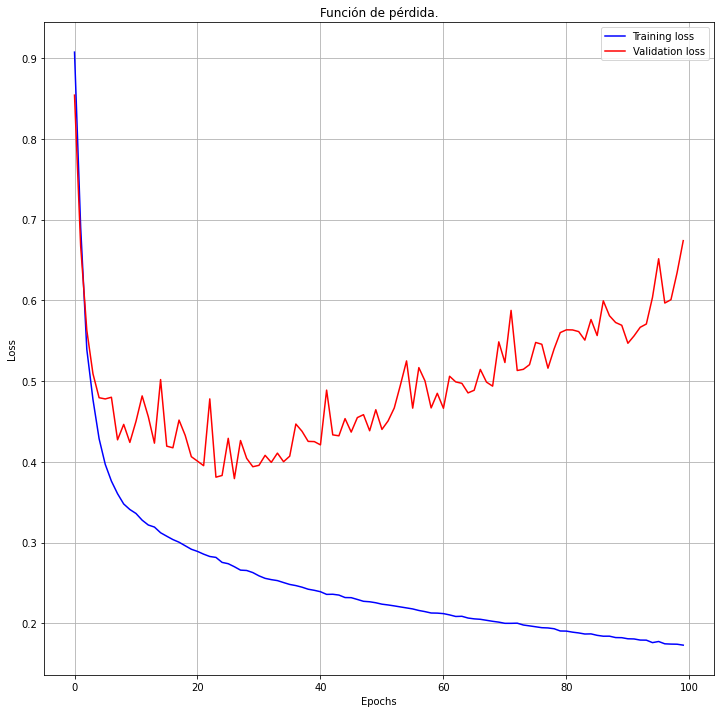

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, 'Función de pérdida.')

In [ ]:
i=0
for batch in LSTM_test:
  if i==5:
    INP , LABS = batch
  i+=1

In [ ]:
modelo06 = k.models.load_model('./AirTime06.h5')
# x_o = INPUT.numpy()[24,0,:]
y_o = LABS.numpy()[:,:,0]
y_predict = modelo06.predict(INPUT)[:,:]


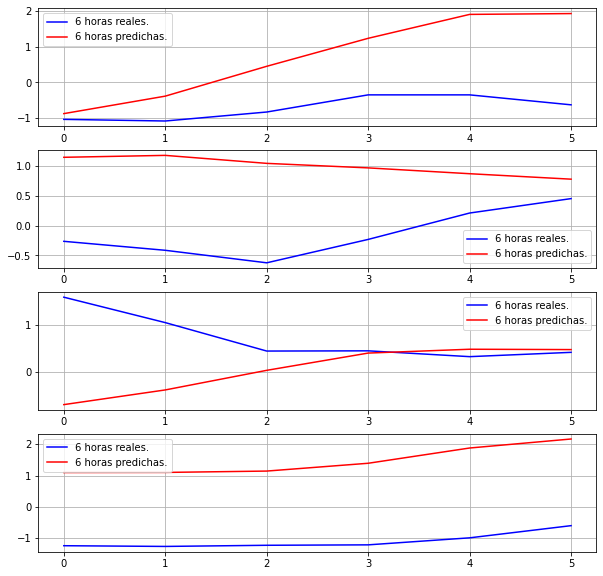

In [ ]:
fig = plt.figure(figsize=(10,10))
a1 = fig.add_subplot(411)
a1.plot(y_o[0], 'b', label='6 horas reales.')
a1.plot(y_predict[0],'r', label='6 horas predichas.')
a1.legend()
a2 = fig.add_subplot(412)
a2.plot(y_o[1], 'b', label='6 horas reales.')
a2.plot(y_predict[1],'r', label='6 horas predichas.')
a2.legend()
a3 = fig.add_subplot(413)
a3.plot(y_o[2], 'b', label='6 horas reales.')
a3.plot(y_predict[2],'r', label='6 horas predichas.')
a3.legend()
a4 = fig.add_subplot(414)
a4.plot(y_o[3], 'b', label='6 horas reales.')
a4.plot(y_predict[3],'r', label='6 horas predichas.')
a4.legend()

In [ ]:
indice_columnas = {str(name): i for i, name in enumerate(trainset.columns)}


def split2_(features):
  inputs = features[:, slice(0,24), :]
  labels = features[:, slice(24,None), :]
  labels = tf.stack([labels[:, :, indice_columnas[name]] for name in ['PT08.S1(CO)']],axis=-1)
  inputs.set_shape([None, 24, None])
  labels.set_shape([None, 10, None])
  return inputs, labels

def make2_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=34,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(split2_)

  return ds


LSTM_train2 = make2_dataset(trainset)
LSTM_val2 = make2_dataset(valset)
LSTM_test2 = make2_dataset(testset)

In [ ]:
INP2 = []
LAB2 = []
for batch in LSTM_val2:
  INPUT2, LABELS2 = batch
  INP2.append(INPUT2)
  LAB2.append(LABELS2)
print('Label shape: ',np.shape(LAB2),'\n')
print('Input shape: ',np.shape(INP2))

Label shape:  (58,) 

Input shape:  (58,)


In [ ]:
import os
time10 = os.getcwd()+'/AirTime10.h5'

In [ ]:
AirTime10Net = k.Sequential()
AirTime10Net.add(LSTM(32, activation='sigmoid', return_sequences=True))
AirTime10Net.add(LSTM(16, activation='relu', return_sequences=False))
AirTime10Net.add(Dense(16, activation='relu'))
AirTime10Net.add(Dense(10))
my_callbacks = k.callbacks.ModelCheckpoint(
    time10,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)
sgd = k.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
AirTime10Net.compile(optimizer=sgd, loss='mse')

In [ ]:
history2 = AirTime10Net.fit(
    LSTM_train2,
    epochs=100,
    validation_data=LSTM_val2,
    callbacks = my_callbacks)

Epoch 1/100
203/203 [==============================] - 5s 23ms/step - loss: 0.9788 - val_loss: 1.0467
Epoch 2/100
203/203 [==============================] - 4s 22ms/step - loss: 0.9002 - val_loss: 0.9161
Epoch 3/100
203/203 [==============================] - 5s 23ms/step - loss: 0.7375 - val_loss: 0.7520
Epoch 4/100
203/203 [==============================] - 5s 23ms/step - loss: 0.6228 - val_loss: 0.6586
Epoch 5/100
203/203 [==============================] - 4s 22ms/step - loss: 0.5474 - val_loss: 0.6218
Epoch 6/100
203/203 [==============================] - 4s 22ms/step - loss: 0.5043 - val_loss: 0.5876
Epoch 7/100
203/203 [==============================] - 4s 21ms/step - loss: 0.4740 - val_loss: 0.6015
Epoch 8/100
203/203 [==============================] - 5s 24ms/step - loss: 0.4486 - val_loss: 0.5985
Epoch 9/100
203/203 [==============================] - 5s 23ms/step - loss: 0.4301 - val_loss: 0.5279
Epoch 10/100
203/203 [==============================] - 5s 22ms/step - loss: 0.416

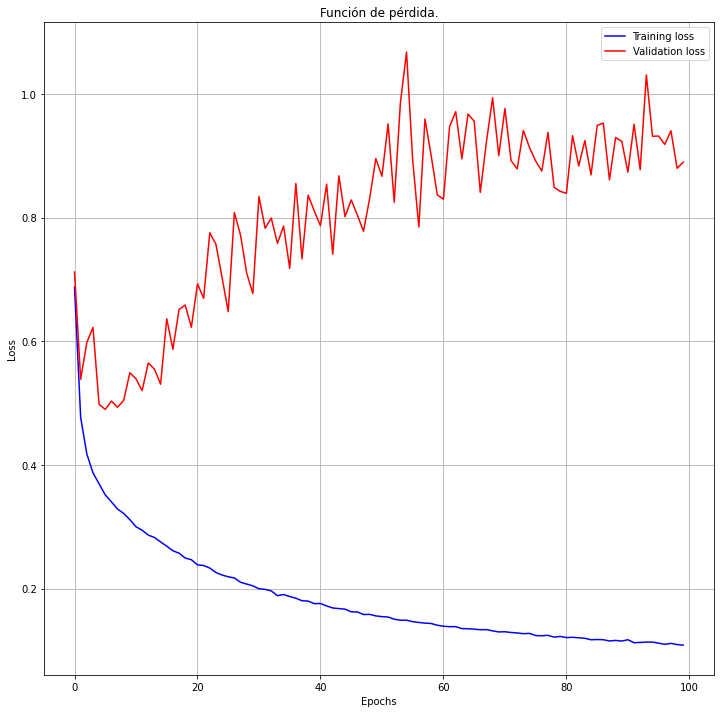

In [ ]:
visualize_loss(history2, 'Función de pérdida.')

In [ ]:
modelo10 = k.models.load_model('./AirTime10.h5')
# x_o = INPUT.numpy()[24,0,:]
y2_o = LABELS2.numpy()[1:,:,0]
y2_predict = modelo10.predict(INPUT2)[1:,:]



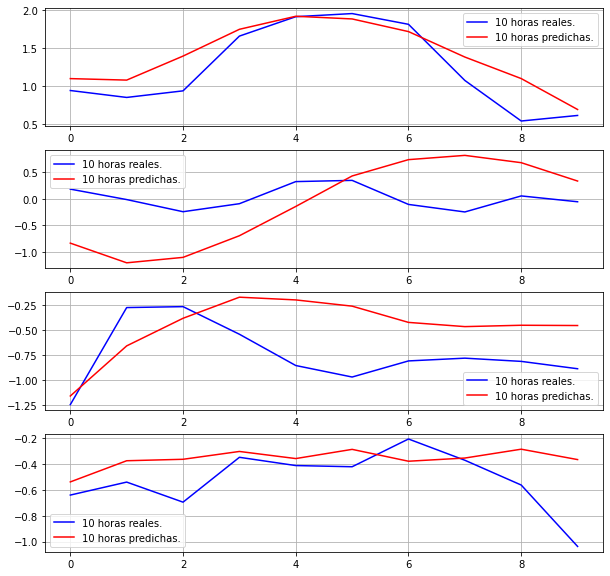

In [ ]:
fig = plt.figure(figsize=(10,10))
a1 = fig.add_subplot(411)
a1.plot(y2_o[0], 'b', label='10 horas reales.')
a1.plot(y2_predict[0],'r', label='10 horas predichas.')
a1.legend()
a2 = fig.add_subplot(412)
a2.plot(y2_o[1], 'b', label='10 horas reales.')
a2.plot(y2_predict[1],'r', label='10 horas predichas.')
a2.legend()
a3 = fig.add_subplot(413)
a3.plot(y2_o[2], 'b', label='10 horas reales.')
a3.plot(y2_predict[2],'r', label='10 horas predichas.')
a3.legend()
a4 = fig.add_subplot(414)
a4.plot(y2_o[3], 'b', label='10 horas reales.')
a4.plot(y2_predict[3],'r', label='10 horas predichas.')
a4.legend()

In [ ]:
indice_columnas = {str(name): i for i, name in enumerate(trainset.columns)}


def split_(features):
  inputs = features[:, slice(0,24), :]
  labels = features[:, slice(24,None), :]
  labels = tf.stack([labels[:, :, indice_columnas[name]] for name in ['PT08.S1(CO)']],axis=-1)
  inputs.set_shape([None, 24, None])
  labels.set_shape([None, 1, None])
  return inputs, labels

def make_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=25,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(split_)

  return ds


LSTM_train1 = make_dataset(trainset)
LSTM_val1 = make_dataset(valset)
LSTM_test1 = make_dataset(testset)

In [ ]:
time_1 = os.getcwd()+'/AirTime01.h5'
AirTimeNet = k.Sequential()
AirTimeNet.add(LSTM(32, activation='sigmoid', return_sequences=True))
AirTimeNet.add(LSTM(16, activation='relu', return_sequences=False))
AirTimeNet.add(Dense(16, activation='relu'))
AirTimeNet.add(Dense(1))
my_callbacks = k.callbacks.ModelCheckpoint(
    time_1,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)
sgd = k.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)
AirTimeNet.compile(optimizer=sgd, loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
history01 = AirTimeNet.fit(
    LSTM_train1,
    epochs=100,
    validation_data=LSTM_val1,
    callbacks = [my_callbacks])

Epoch 1/100
203/203 [==============================] - 5s 23ms/step - loss: 0.3470 - mean_absolute_error: 0.4337 - val_loss: 0.4285 - val_mean_absolute_error: 0.5442
Epoch 2/100
203/203 [==============================] - 4s 22ms/step - loss: 0.1741 - mean_absolute_error: 0.3110 - val_loss: 0.1952 - val_mean_absolute_error: 0.3216
Epoch 3/100
203/203 [==============================] - 5s 23ms/step - loss: 0.1548 - mean_absolute_error: 0.2913 - val_loss: 0.1688 - val_mean_absolute_error: 0.3011
Epoch 4/100
203/203 [==============================] - 4s 22ms/step - loss: 0.1484 - mean_absolute_error: 0.2829 - val_loss: 0.1500 - val_mean_absolute_error: 0.2833
Epoch 5/100
203/203 [==============================] - 4s 22ms/step - loss: 0.1429 - mean_absolute_error: 0.2785 - val_loss: 0.1597 - val_mean_absolute_error: 0.2967
Epoch 6/100
203/203 [==============================] - 4s 22ms/step - loss: 0.1385 - mean_absolute_error: 0.2740 - val_loss: 0.1568 - val_mean_absolute_error: 0.2870
Epoc

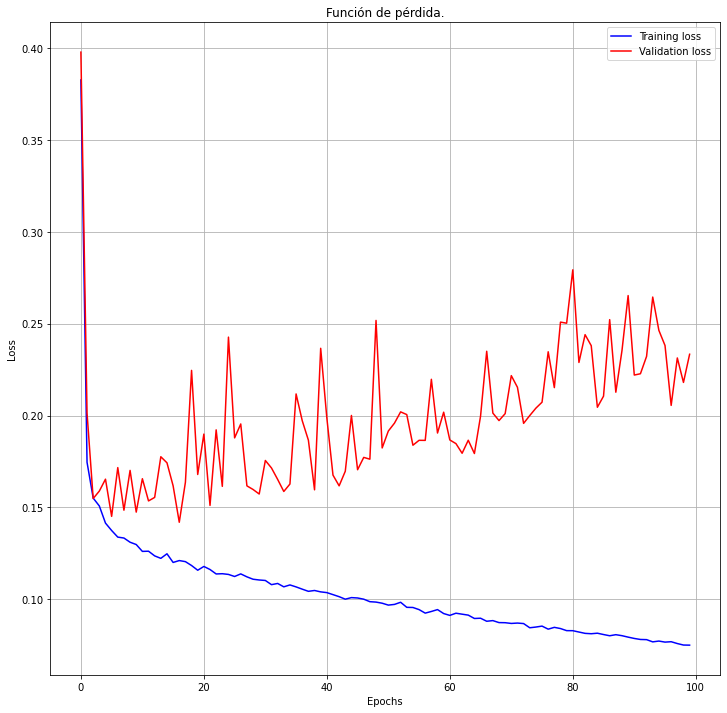

In [ ]:
visualize_loss(history01, 'Función de pérdida.')

In [ ]:
modelo01 = k.models.load_model('./AirTime01.h5')
pred01 = []
labs01 = []
for batch in LSTM_test1:
  IN01 , LAB01 = batch
  LABPRED = modelo01.predict(IN01)
  for i in range(11):
    labs01.append(LAB01.numpy()[:,0,0][i])
  for i in range(11):
    pred01.append(LABPRED[:,0][i])

In [ ]:
len(pred01)

319

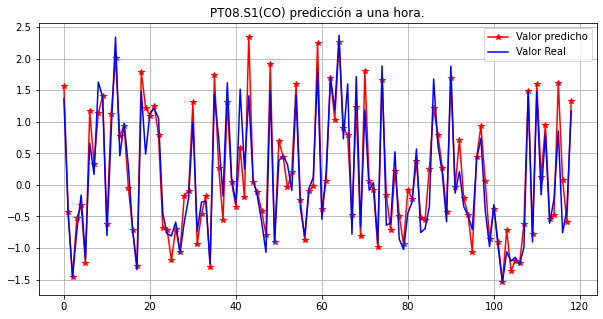

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(pred01[100:-100],'*-', color ='r',label='Valor predicho')
plt.plot(labs01[100:-100],'b',label='Valor Real')
plt.legend()
plt.title('PT08.S1(CO) predicción a una hora.')
plt.savefig('Modelo_h1_test.pdf')

In [ ]:
modelo01.evaluate(LSTM_train1)

203/203 [==============================] - 2s 9ms/step - loss: 0.1245 - mean_absolute_error: 0.2600


[0.12446623295545578, 0.2599562406539917]

In [ ]:
(std[0]**2)*0.1245

5938.211553055653

In [ ]:
std[0]*0.2600

56.78276090183567

In [ ]:
modelo01.evaluate(LSTM_test1)

29/29 [==============================] - 0s 7ms/step - loss: 0.0990 - mean_absolute_error: 0.2283


[0.0989757627248764, 0.22826939821243286]

In [ ]:
(std[0]**2)*0.0990

4721.951355441845

In [ ]:
std[0]*0.2283

49.85963197649647

In [ ]:
indice_columnas = {str(name): i for i, name in enumerate(trainset.columns)}


def split_(features):
  inputs = features[:, slice(0,24), :]
  labels = features[:, slice(24,None), :]
  labels = tf.stack([labels[:, :, indice_columnas[name]] for name in ['PT08.S1(CO)']],axis=-1)
  inputs.set_shape([None, 24, None])
  labels.set_shape([None, 24, None])
  return inputs, labels

def make_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=48,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(split_)

  return ds


LSTM_train24 = make_dataset(trainset)
LSTM_val24 = make_dataset(valset)
LSTM_test24 = make_dataset(testset)

In [ ]:
time_24 = os.getcwd()+'/AirTime24.h5'
AirTimeNet = k.Sequential()
AirTimeNet.add(LSTM(64, activation='sigmoid', return_sequences=True))
AirTimeNet.add(LSTM(32, activation='relu', return_sequences=False))
AirTimeNet.add(Dense(64, activation='relu'))
AirTimeNet.add(Dense(24))
my_callbacks = k.callbacks.ModelCheckpoint(
    time_24,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)
sgd = k.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.5, nesterov=True)
AirTimeNet.compile(optimizer=sgd, loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
history01 = AirTimeNet.fit(
    LSTM_train24,
    epochs=100,
    validation_data=LSTM_val24,
    callbacks = [my_callbacks])

Epoch 1/100
203/203 [==============================] - 6s 30ms/step - loss: 0.8398 - mean_absolute_error: 0.7244 - val_loss: 0.9240 - val_mean_absolute_error: 0.7821
Epoch 2/100
203/203 [==============================] - 6s 28ms/step - loss: 0.6521 - mean_absolute_error: 0.6275 - val_loss: 0.7109 - val_mean_absolute_error: 0.6442
Epoch 3/100
203/203 [==============================] - 6s 28ms/step - loss: 0.5262 - mean_absolute_error: 0.5539 - val_loss: 0.6677 - val_mean_absolute_error: 0.6176
Epoch 4/100
203/203 [==============================] - 6s 28ms/step - loss: 0.4745 - mean_absolute_error: 0.5219 - val_loss: 0.6355 - val_mean_absolute_error: 0.6179
Epoch 5/100
203/203 [==============================] - 6s 28ms/step - loss: 0.4553 - mean_absolute_error: 0.5090 - val_loss: 0.6213 - val_mean_absolute_error: 0.6036
Epoch 6/100
203/203 [==============================] - 6s 28ms/step - loss: 0.4434 - mean_absolute_error: 0.5012 - val_loss: 0.8452 - val_mean_absolute_error: 0.7249
Epoc

In [ ]:
modelo24 = k.models.load_model('./AirTime24.h5')

In [ ]:
modelo24.evaluate(LSTM_train24)

203/203 [==============================] - 2s 10ms/step - loss: 0.4340 - mean_absolute_error: 0.4906


[0.4340182840824127, 0.49060967564582825]

In [ ]:
0.4340*std[0]**2

20700.271598603642

In [ ]:
0.4906*std[0]

107.14470191707915

In [ ]:
modelo24.evaluate(LSTM_test24)

28/28 [==============================] - 0s 11ms/step - loss: 0.3826 - mean_absolute_error: 0.4791


[0.3825504779815674, 0.4791017770767212]

In [ ]:
0.3826*std[0]**2

18248.672612040908

In [ ]:
0.4791*std[0]

104.63315672334411

In [ ]:
Batches24 = []
for bat in LSTM_test24.as_numpy_iterator():
  Batches24.append(bat)

In [ ]:
Batches24 = np.array(Batches24)

In [ ]:
YPRED = []
YREAL = []
for i in range(32):
  y24_pred = modelo24.predict(Batches24[0,0])[i,:]
  y24_real = Batches24[0,1][i,:,0]
  for x0 in y24_pred:
    YPRED.append(x0)
  for x1 in y24_real:
    YREAL.append(x1)


len(YPRED)==len(YREAL)

True

Text(0.5, 1.0, 'Comparación predicción función test.')

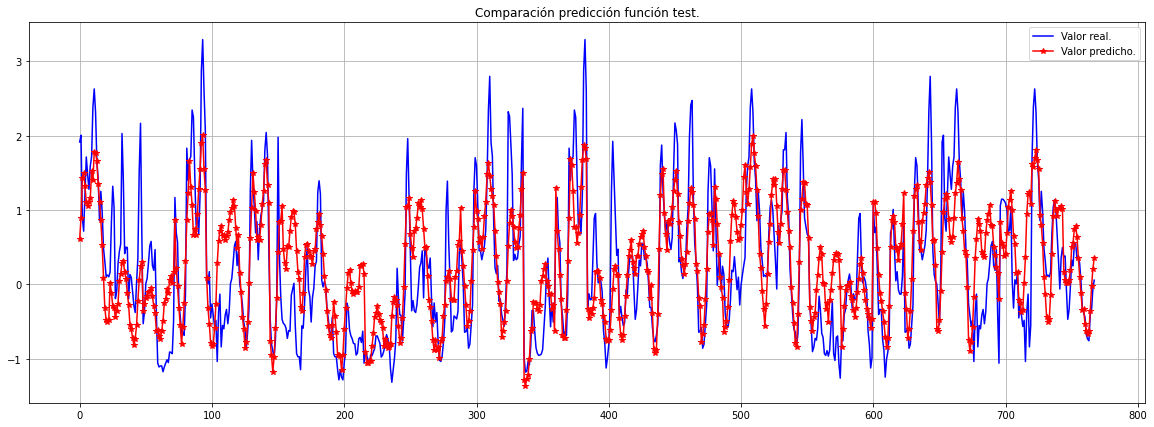

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(YREAL,'b',label='Valor real.')
plt.plot(YPRED,'*-r',label='Valor predicho.')
plt.legend()
plt.title('Comparación predicción función test.')

In [ ]:
p24 = modelo24.predict(Batches24[2,0])
lab24 = Batches24[2,1][:,:,0]
lab24.shape

(32, 24)

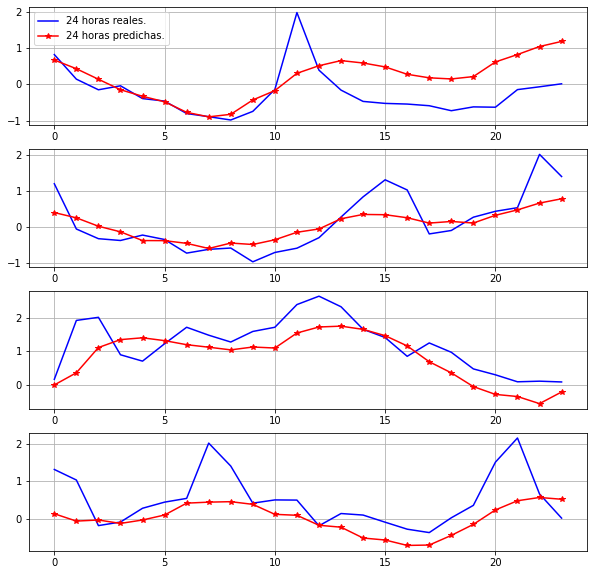

In [ ]:
fig = plt.figure(figsize=(10,10))
a1 = fig.add_subplot(411)
a1.plot(lab24[0,:], 'b', label='24 horas reales.')
a1.plot(p24[0,:],'*-',color='r', label='24 horas predichas.')
a1.legend()
a2 = fig.add_subplot(412)
a2.plot(lab24[3,:], 'b', label='24 horas reales.')
a2.plot(p24[3,:],'*-',color='r', label='24 horas predichas.')

a3 = fig.add_subplot(413)
a3.plot(lab24[15,:], 'b', label='24 horas reales.')
a3.plot(p24[15,:],'*-',color='r', label='24 horas predichas.')

a4 = fig.add_subplot(414)
a4.plot(lab24[27,:], 'b', label='24 horas reales.')
a4.plot(p24[27,:],'*-',color='r', label='24 horas predichas.')
